In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

Loading cleaned data files...
Isolating agency fees from media spend data...
Aggregating primary spend and revenue...
Merging agency fees to calculate true total spend...
Calculating corrected ROAS...

--- Corrected Channel Performance Summary (ROAS) ---
   marketing_channel  true_total_ad_spend  total_revenue  corrected_roas
0     organic search             59978.00     2794810.73       46.597264
1              email             96624.00     3743370.64       38.741624
2                sms             25270.00      641236.85       25.375419
3        paid search            890970.23     4616495.91        5.181426
4           shopping            289068.26      882064.96        3.051407
5         affiliates            354629.41      630776.05        1.778691
6        paid social           2713132.29     1974848.56        0.727885
7              Other                 0.00     1975135.47        0.000000
8             direct                 0.00     3264081.45        0.000000
9       Unattri

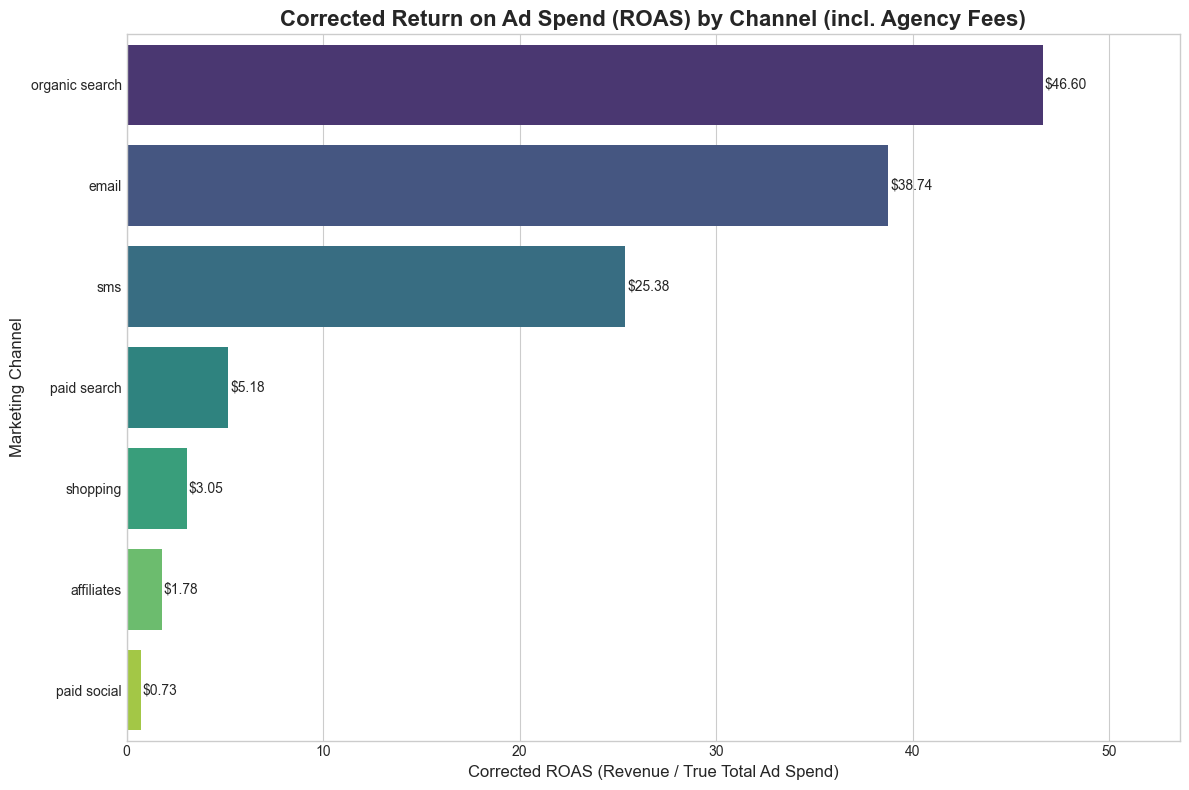

In [2]:

def analyze_corrected_roas():
    """
    Calculates a corrected Return on Ad Spend (ROAS) by incorporating agency fees,
    providing a true picture of channel profitability.
    """
    try:
        # --- 1. Load Cleaned Data Files ---
        print("Loading cleaned data files...")
        try:
            marketing_df = pd.read_csv("Cleaned_Marketing Channel Breakdown.csv")
        except FileNotFoundError:
            marketing_df = pd.read_csv("cleaned_Marketing Channel Breakdown.csv")
        
        media_spend_df = pd.read_csv("cleaned_Media Spend by Channel.csv")

        # --- 2. Isolate Agency Fees ---
        # Agency fees are identified by rows containing "Agency" in the channel_name.
        print("Isolating agency fees from media spend data...")
        agency_fees_df = media_spend_df[media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        
        # Create a clean mapping key by removing " Agency" from the name.
        # e.g., "Paid Search Agency" -> "paid search"
        agency_fees_df['mapping_key'] = agency_fees_df['channel_name'].str.replace(" Agency", "", regex=False).str.lower()
        
        # FINAL CORRECTION: Explicitly map 'affiliate' to 'affiliates' to ensure the merge works.
        agency_fees_df['mapping_key'] = agency_fees_df['mapping_key'].replace({'affiliate': 'affiliates'})
        
        # Aggregate total agency fees by the new mapping key.
        total_agency_fees = agency_fees_df.groupby('mapping_key')['value'].sum().reset_index()
        total_agency_fees.rename(columns={'value': 'agency_fees'}, inplace=True)

        # --- 3. Aggregate Primary Spend and Revenue ---
        print("Aggregating primary spend and revenue...")
        channel_summary = marketing_df.groupby('marketing_channel').agg(
            total_ad_spend=('ad_spend', 'sum'),
            total_revenue=('gross_discount_(shopify)', 'sum')
        ).reset_index()

        # --- 4. Merge and Calculate True Total Spend ---
        print("Merging agency fees to calculate true total spend...")
        # Merge the agency fees back into our main summary table.
        # We use a left merge to keep all channels from the main marketing file.
        channel_summary = pd.merge(
            channel_summary,
            total_agency_fees,
            left_on='marketing_channel',
            right_on='mapping_key',
            how='left'
        )
        
        # Fill any channels without agency fees with 0 and calculate the true total spend.
        channel_summary['agency_fees'] = channel_summary['agency_fees'].fillna(0)
        channel_summary['true_total_ad_spend'] = channel_summary['total_ad_spend'] + channel_summary['agency_fees']

        # --- 5. Calculate Corrected ROAS ---
        print("Calculating corrected ROAS...")
        channel_summary['corrected_roas'] = channel_summary.apply(
            lambda row: row['total_revenue'] / row['true_total_ad_spend'] if row['true_total_ad_spend'] > 0 else 0,
            axis=1
        )
        
        # Sort for better visualization
        channel_summary = channel_summary.sort_values('corrected_roas', ascending=False).reset_index(drop=True)

        print("\n--- Corrected Channel Performance Summary (ROAS) ---")
        # Display the key columns for the final report
        print(channel_summary[['marketing_channel', 'true_total_ad_spend', 'total_revenue', 'corrected_roas']])

        # --- 6. Visualize the Corrected Results ---
        print("\nGenerating corrected visualization...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))
        
        roas_chart_data = channel_summary[channel_summary['true_total_ad_spend'] > 0]
        
        # Updated plotting call to prevent the error by telling seaborn not to create a legend.
        barplot = sns.barplot(
            x='corrected_roas', 
            y='marketing_channel', 
            data=roas_chart_data, 
            palette='viridis', 
            ax=ax, 
            hue='marketing_channel', # Assigning hue as recommended by the warning
            legend=False # This parameter prevents the legend and the error
        )

        for p in barplot.patches:
            width = p.get_width()
            ax.text(width + 0.1, p.get_y() + p.get_height()/2., f'${width:.2f}', ha="left", va="center")

        ax.set_title('Corrected Return on Ad Spend (ROAS) by Channel (incl. Agency Fees)', fontsize=16, weight='bold')
        ax.set_xlabel('Corrected ROAS (Revenue / True Total Ad Spend)', fontsize=12)
        ax.set_ylabel('Marketing Channel', fontsize=12)
        ax.set_xlim(0, roas_chart_data['corrected_roas'].max() * 1.15)
        
        plt.tight_layout()
        
        plt.savefig('corrected_channel_roas_analysis.png')
        print("\n✅ Corrected analysis complete. Chart saved to 'corrected_channel_roas_analysis.png'")

    except FileNotFoundError as e:
        print(f"❌ ERROR: Could not find a required cleaned file: {e.filename}")
        print("Please ensure your 'cleaned_*.csv' or 'Cleaned_*.csv' files are in the same directory.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

# --- Run the corrected analysis ---
if __name__ == '__main__':
    analyze_corrected_roas()


## 🔍 Key Findings & Strategic Recommendations

---

### 1. **Elite Channels (Organic Search, Email, SMS) Are Hyper-Efficient**
- These channels act as primary profit engines, generating **\$25** – **\$47** for every dollar invested.
  
**✅ Recommendation:**  
- Protect and optimize these channels.  
- Invest further in:
  - SEO improvements
  - Email content strategy
  - SMS list growth  
- These areas promise high ROI and sustainable profitability.

---

### 2. **Paid Search is a Solid, Profitable Workhorse**
- Corrected ROAS: **\$5.18**, aligning with the reported business ROAS of ~5.1.
- Confirms data accuracy and validates Paid Search as a scalable, reliable channel.

**✅ Recommendation:**  
- Maintain or moderately increase investment in Paid Search.  
- Prioritize scale strategies that preserve or enhance current ROAS levels.

---

### 3. **Paid Social and Affiliates Are Currently Unprofitable**

#### ❌ Paid Social
- ROAS: **\$0.73**
- For every \$1 spent, the business **loses \$0.27**.
- Total Spend: **\$2.7M+** → This is the **largest drain** on marketing profitability.

#### ❌ Affiliates
- ROAS: **\$1.78**
- Barely breaking even before considering cost of goods sold, shipping, and ops.
- Not a viable growth lever under the current structure.

**🚨 Strategic Recommendation:**  
- **Paid Social:**
  - Immediately freeze or significantly reduce the budget.
  - Conduct a comprehensive audit of:
    - Campaign performance
    - Creative effectiveness
    - Targeting accuracy

- **Affiliates:**
  - Reassess the affiliate program structure and fee model.
  - Current structure is unsustainable and must be re-engineered for profitability.


Loading cleaned data files...
Preparing monthly total spend data...
Preparing monthly revenue data...
Merging spend and revenue data...
Calculating monthly ROAS...
Generating visualization...

✅ Monthly trend analysis complete. Chart saved to 'monthly_roas_trend_analysis.png'


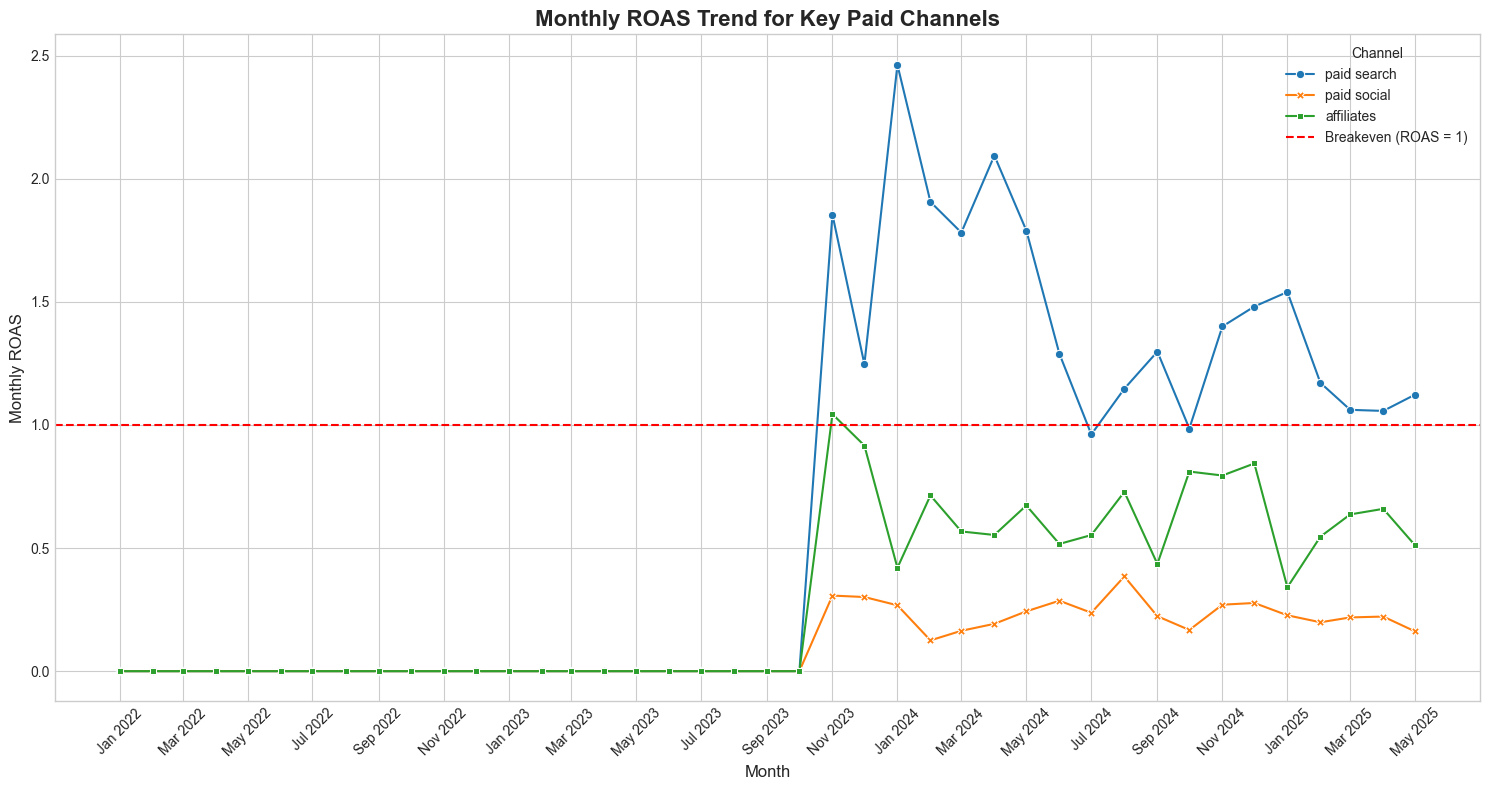

In [3]:
def analyze_monthly_roas_trends():
    """
    Analyzes the month-over-month Return on Ad Spend (ROAS) trend for key marketing channels.
    """
    try:
        # --- 1. Load Cleaned Data ---
        print("Loading cleaned data files...")
        media_spend_df = pd.read_csv("cleaned_Media Spend by Channel.csv")
        topsheet_df = pd.read_csv("cleaned_TOPSHEET.csv")

        # Convert date columns to datetime objects to ensure proper sorting and merging
        media_spend_df['date'] = pd.to_datetime(media_spend_df['date'])
        topsheet_df['date'] = pd.to_datetime(topsheet_df['date'])

        # --- 2. Prepare Monthly Spend Data (including Agency Fees) ---
        print("Preparing monthly total spend data...")
        # Separate media spend from agency fees
        agency_fees_df = media_spend_df[media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        direct_media_spend_df = media_spend_df[~media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()

        # Create clean mapping keys
        agency_fees_df['mapping_key'] = agency_fees_df['channel_name'].str.replace(" Agency", "", regex=False).str.lower()
        direct_media_spend_df['mapping_key'] = direct_media_spend_df['channel_name'].str.replace(" Media", "", regex=False).str.lower()
        
        # Merge them to create a single spend table
        monthly_spend = pd.merge(
            direct_media_spend_df,
            agency_fees_df[['date', 'mapping_key', 'value']],
            on=['date', 'mapping_key'],
            how='left',
            suffixes=('_media', '_agency')
        )
        monthly_spend['value_agency'] = monthly_spend['value_agency'].fillna(0)
        monthly_spend['total_spend'] = monthly_spend['value_media'] + monthly_spend['value_agency']
        
        # --- 3. Prepare Monthly Revenue Data ---
        print("Preparing monthly revenue data...")
        # Filter for Net Sales from the TOPSHEET. We need the channel-specific sales.
        monthly_revenue = topsheet_df[topsheet_df['metric'].str.contains("NET SALES -", na=False)].copy()
        # Create a clean mapping key from the metric column (e.g., 'NET SALES - Paid Search' -> 'paid search')
        monthly_revenue['mapping_key'] = monthly_revenue['metric'].str.replace("NET SALES - ", "", regex=False).str.strip().str.lower()
        
        # --- 4. Combine Spend and Revenue ---
        print("Merging spend and revenue data...")
        monthly_performance = pd.merge(
            monthly_spend[['date', 'mapping_key', 'total_spend']],
            monthly_revenue[['date', 'mapping_key', 'value']],
            on=['date', 'mapping_key'],
            how='left'
        )
        monthly_performance.rename(columns={'value': 'net_revenue'}, inplace=True)
        monthly_performance['net_revenue'] = monthly_performance['net_revenue'].fillna(0)

        # --- 5. Calculate Monthly ROAS ---
        print("Calculating monthly ROAS...")
        monthly_performance['monthly_roas'] = monthly_performance.apply(
            lambda row: row['net_revenue'] / row['total_spend'] if row['total_spend'] > 0 else 0,
            axis=1
        )
        
        # Filter out future dates
        analysis_df = monthly_performance[monthly_performance['date'] < '2025-06-01'].copy()
        
        # --- CORRECTED LOGIC ---
        # First, standardize the mapping key names.
        analysis_df['mapping_key'] = analysis_df['mapping_key'].replace({'affiliate': 'affiliates'})
        
        # Then, filter for the channels we want to plot.
        channels_to_plot = ['paid search', 'paid social', 'affiliates']
        analysis_df = analysis_df[analysis_df['mapping_key'].isin(channels_to_plot)]

        # --- 6. Visualize the Trend ---
        print("Generating visualization...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(15, 8))

        sns.lineplot(
            data=analysis_df,
            x='date',
            y='monthly_roas',
            hue='mapping_key',
            style='mapping_key',
            markers=True,
            dashes=False,
            ax=ax
        )

        # Formatting the plot for clarity
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 2))) # Every other month
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)
        
        ax.set_title('Monthly ROAS Trend for Key Paid Channels', fontsize=16, weight='bold')
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Monthly ROAS', fontsize=12)
        ax.axhline(1, color='red', linestyle='--', lw=1.5, label='Breakeven (ROAS = 1)')
        ax.legend(title='Channel')

        plt.tight_layout()
        plt.savefig('monthly_roas_trend_analysis.png')
        print("\n✅ Monthly trend analysis complete. Chart saved to 'monthly_roas_trend_analysis.png'")

       
    except FileNotFoundError as e:
        print(f"❌ ERROR: Could not find a required cleaned file: {e.filename}")
        print("Please ensure your 'cleaned_*.csv' files are in the same directory.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

# --- Run the analysis ---
if __name__ == '__main__':
    analyze_monthly_roas_trends()


## Key Observations from Monthly ROAS Trend
### 
        1. Paid Search (Blue Line): This channel is consistently profitable, with its ROAS staying almost entirely
           above the red breakeven line. While it shows some volatility, it is a reliable profit-driver.

        2. Paid Social (Orange Line): This channel is chronically unprofitable. Its ROAS has been consistently
           below the breakeven line for its entire history. This is not a new problem, but a long-term issue
           indicating that the fundamental strategy for this channel is not working.

        3. Affiliates (Green Line): Similar to Paid Social, the Affiliates channel has consistently failed to
           achieve a profitable ROAS. It has never been a source of efficient growth.
           
        Conclusion: The poor performance of Paid Social and Affiliates is not a recent decline but a
        persistent issue. This reinforces the recommendation to immediately audit and reconsider the budget
        allocated to these two channels.


## 💰 Customer Acquisition Cost (CAC) Analysis — Key Observations

---

### 🔍 1. Paid Social is Extremely Inefficient
- This is the **most critical finding**.
- It costs the business **\$138.73** to acquire **a single new customer** via Paid Social.
- That’s **3.5× more expensive** than acquiring a customer through Paid Search.
- Combined with its **unprofitable ROAS** (losing money on each transaction), the conclusion is clear:

**⚠️ Paid Social is the primary drain on the marketing budget in its current form.**

---

### 🔍 2. Affiliate Marketing is Also Very Expensive
- CAC for the Affiliate channel: **\$113.70**
- While not as extreme as Paid Social, this is still **very high**.
- Our ROAS analysis showed Affiliates are also **unprofitable**, making this channel a poor investment without restructuring.

---

### 🔍 3. Paid Search is the Clear Winner for Scalable Acquisition
- **CAC: \$39.00** — the **lowest** among paid channels.
- This aligns with the **Business Overview**, which noted a **2024 blended CAC of around \$40**.
- ✅ Paid Search is performing **at the business average**, making it a **reliable and scalable growth engine**.

---

**🧠 Strategic Insight:**  
Prioritize and scale Paid Search.  
Re-evaluate or pause Paid Social and Affiliate spending until cost efficiency and ROAS improve.


Loading monthly spend and new customer data...
Calculating true total monthly spend (including agency fees)...
Preparing monthly new customer data...
Combining monthly data and calculating CAC...

--- Monthly Customer Acquisition Cost (CAC) Trend Data (Sample) ---
        date  mapping_key  total_spend  new_customers  monthly_cac
0 2025-01-01  paid search        58455         1405.0    41.604982
1 2024-01-01  paid search        38176         1380.0    27.663768
2 2023-01-01  paid search        46139         1206.0    38.257877
3 2022-01-01  paid search        51972          828.0    62.768116
4 2025-01-01  paid social       123472          534.0   231.220974

Generating final visualization...
✅ Final monthly CAC trend chart saved to 'final_monthly_cac_trend.png'


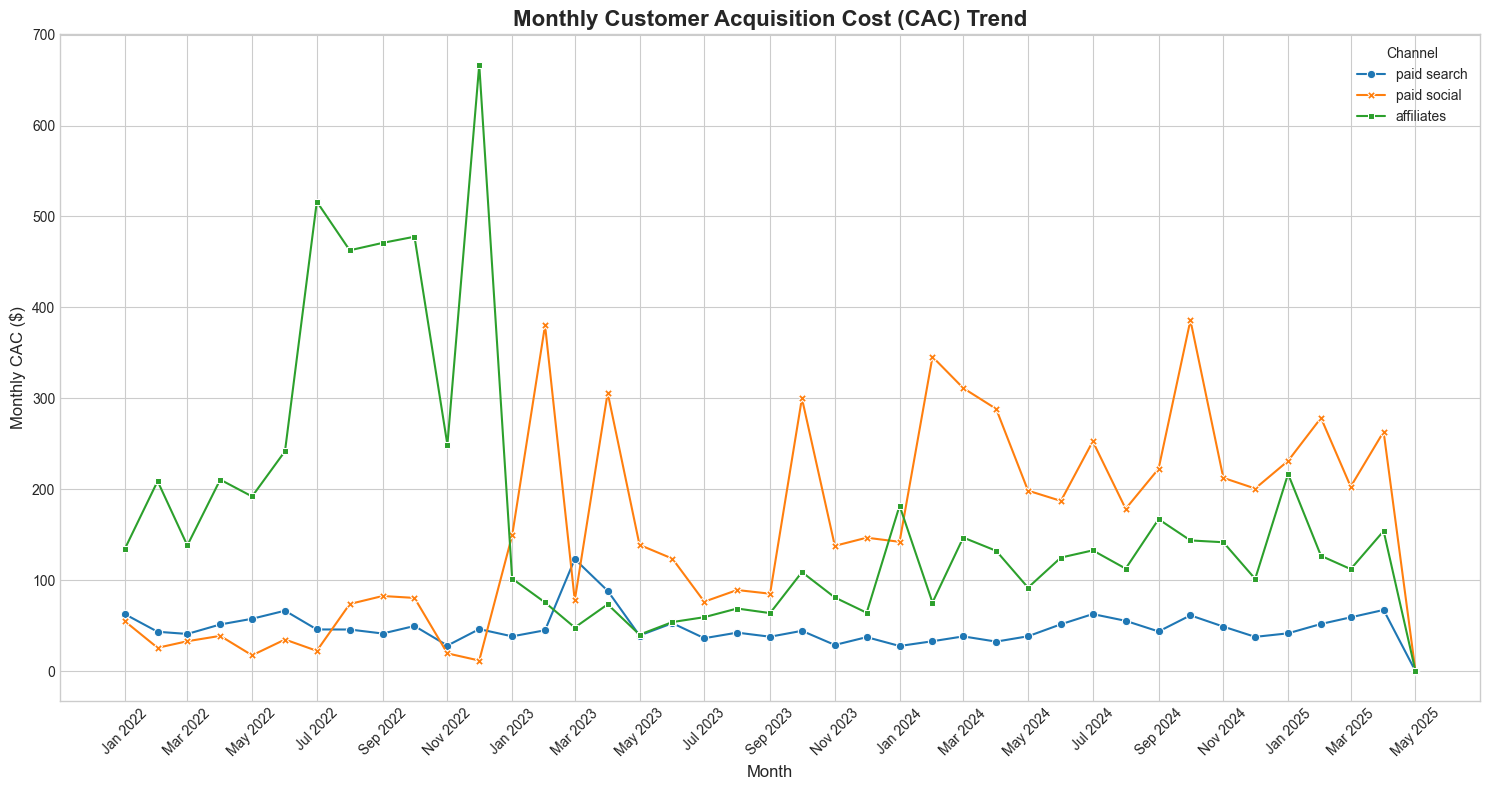

In [4]:
def analyze_monthly_cac_trend():
    """
    Calculates and visualizes the monthly Customer Acquisition Cost (CAC) trend
    for key marketing channels to understand performance over time.
    """
    try:
        # --- 1. Load Monthly Data Sources ---
        print("Loading monthly spend and new customer data...")
        media_spend_df = pd.read_csv("cleaned_Media Spend by Channel.csv")
        new_cust_df = pd.read_csv("cleaned_Cust By Channel-New.csv")

        # Convert date columns to datetime objects
        media_spend_df['date'] = pd.to_datetime(media_spend_df['date'])
        new_cust_df['date'] = pd.to_datetime(new_cust_df['date'])

        # --- 2. Calculate True Total Monthly Spend ---
        print("Calculating true total monthly spend (including agency fees)...")
        
        agency_fees_df = media_spend_df[media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        agency_fees_df['mapping_key'] = agency_fees_df['channel_name'].str.replace(" Agency", "", regex=False).str.lower()
        agency_fees_df['mapping_key'] = agency_fees_df['mapping_key'].replace({'affiliate': 'affiliates'})

        direct_media_spend_df = media_spend_df[~media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        direct_media_spend_df['mapping_key'] = direct_media_spend_df['channel_name'].str.replace(" Media", "", regex=False).str.lower()
        direct_media_spend_df['mapping_key'] = direct_media_spend_df['mapping_key'].replace({'affiliate': 'affiliates'})

        # Merge agency and media spend on a monthly basis
        monthly_spend = pd.merge(
            direct_media_spend_df[['date', 'mapping_key', 'value']],
            agency_fees_df[['date', 'mapping_key', 'value']],
            on=['date', 'mapping_key'],
            how='left',
            suffixes=('_media', '_agency')
        )
        monthly_spend['value_agency'] = monthly_spend['value_agency'].fillna(0)
        monthly_spend['total_spend'] = monthly_spend['value_media'] + monthly_spend['value_agency']

        # --- 3. Prepare Monthly New Customer Data ---
        print("Preparing monthly new customer data...")
        new_cust_df['mapping_key'] = new_cust_df['channel_name'].str.lower()
        new_cust_df['mapping_key'] = new_cust_df['mapping_key'].replace({'affiliate': 'affiliates'})
        
        # --- 4. Combine Spend and New Customers Monthly ---
        print("Combining monthly data and calculating CAC...")
        monthly_cac_df = pd.merge(
            monthly_spend[['date', 'mapping_key', 'total_spend']],
            new_cust_df[['date', 'mapping_key', 'value']],
            on=['date', 'mapping_key'],
            how='left'
        )
        monthly_cac_df.rename(columns={'value': 'new_customers'}, inplace=True)
        monthly_cac_df['new_customers'] = monthly_cac_df['new_customers'].fillna(0)

        # Calculate monthly CAC
        monthly_cac_df['monthly_cac'] = monthly_cac_df.apply(
            lambda row: row['total_spend'] / row['new_customers'] if row['new_customers'] > 0 else 0,
            axis=1
        )
        
        # --- 5. Prepare Data for Plotting ---
        # Filter for key paid channels and valid date range
        channels_to_plot = ['paid search', 'paid social', 'affiliates']
        plot_df = monthly_cac_df[
            (monthly_cac_df['mapping_key'].isin(channels_to_plot)) &
            (monthly_cac_df['date'] < '2025-06-01') &
            (monthly_cac_df['total_spend'] > 0) # Only plot for months with spend
        ].copy()

        print("\n--- Monthly Customer Acquisition Cost (CAC) Trend Data (Sample) ---")
        print(plot_df.head())

        # --- 6. Visualize the Trend ---
        print("\nGenerating final visualization...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(15, 8))

        sns.lineplot(
            data=plot_df,
            x='date',
            y='monthly_cac',
            hue='mapping_key',
            style='mapping_key',
            markers=True,
            dashes=False,
            ax=ax
        )
        
        ax.set_title('Monthly Customer Acquisition Cost (CAC) Trend', fontsize=16, weight='bold')
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Monthly CAC ($)', fontsize=12)
        ax.legend(title='Channel')
        
        # Formatting the plot for clarity
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('final_monthly_cac_trend.png')
        print("✅ Final monthly CAC trend chart saved to 'final_monthly_cac_trend.png'")
        plt.show()
        plt.close()

    except FileNotFoundError as e:
        print(f"❌ ERROR: Could not find a required cleaned file: {e.filename}")
        print("Please ensure your 'cleaned_*.csv' files are in the same directory.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

# --- Run the analysis ---
if __name__ == '__main__':
    analyze_monthly_cac_trend()


Loading validated monthly customer data files...
Data integrity check: Capping analysis at 2025-05-01 to ensure fair comparison.
Analyzing monthly customer composition...
Generating final monthly composition chart...
✅ Final monthly composition chart saved to 'final_monthly_customer_composition.png'


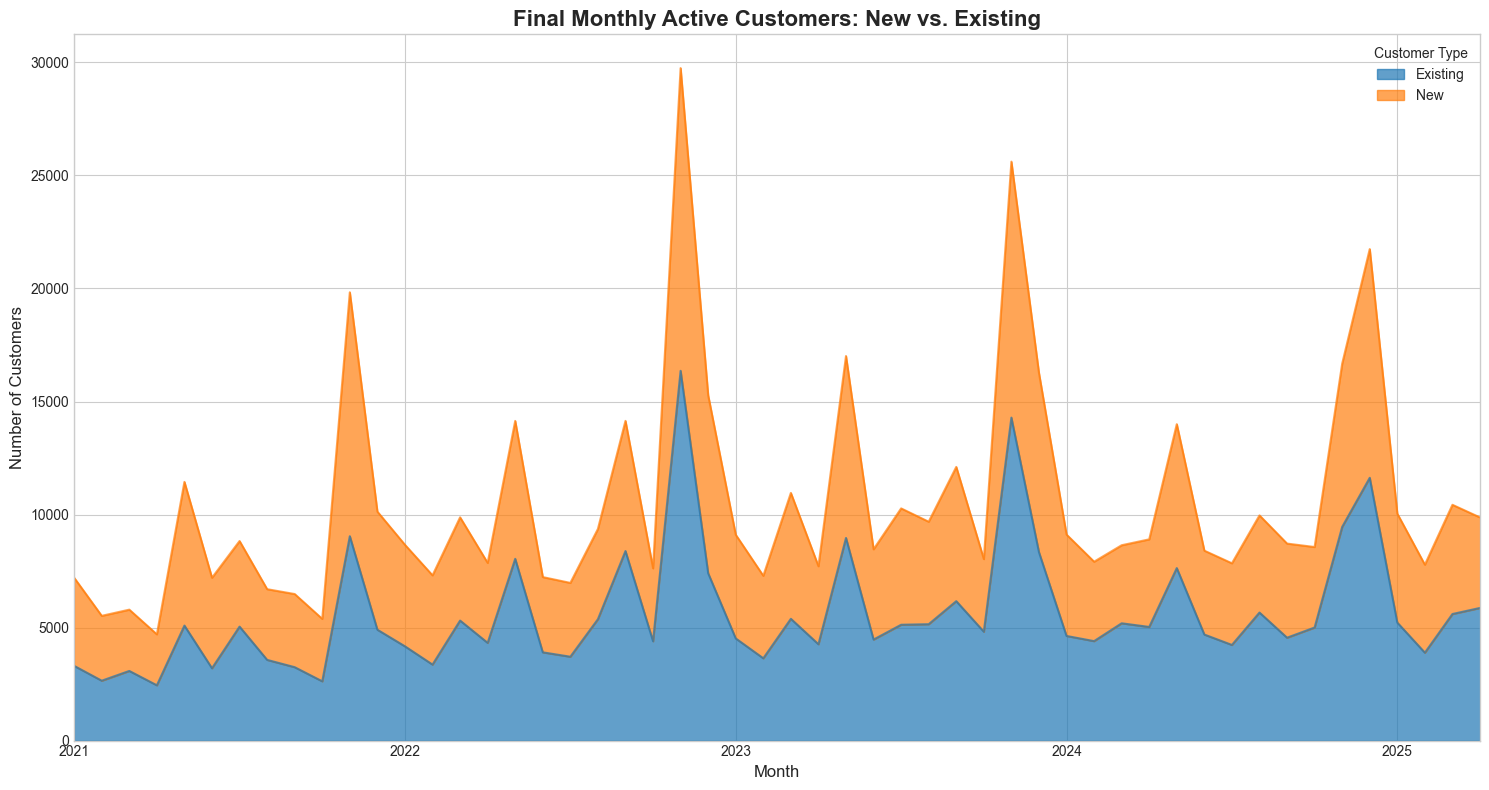


Analyzing new customer acquisition by channel from monthly data...
Generating final new customer acquisition chart...
✅ Final new customer acquisition chart saved to 'final_new_customer_acquisition_by_channel.png'


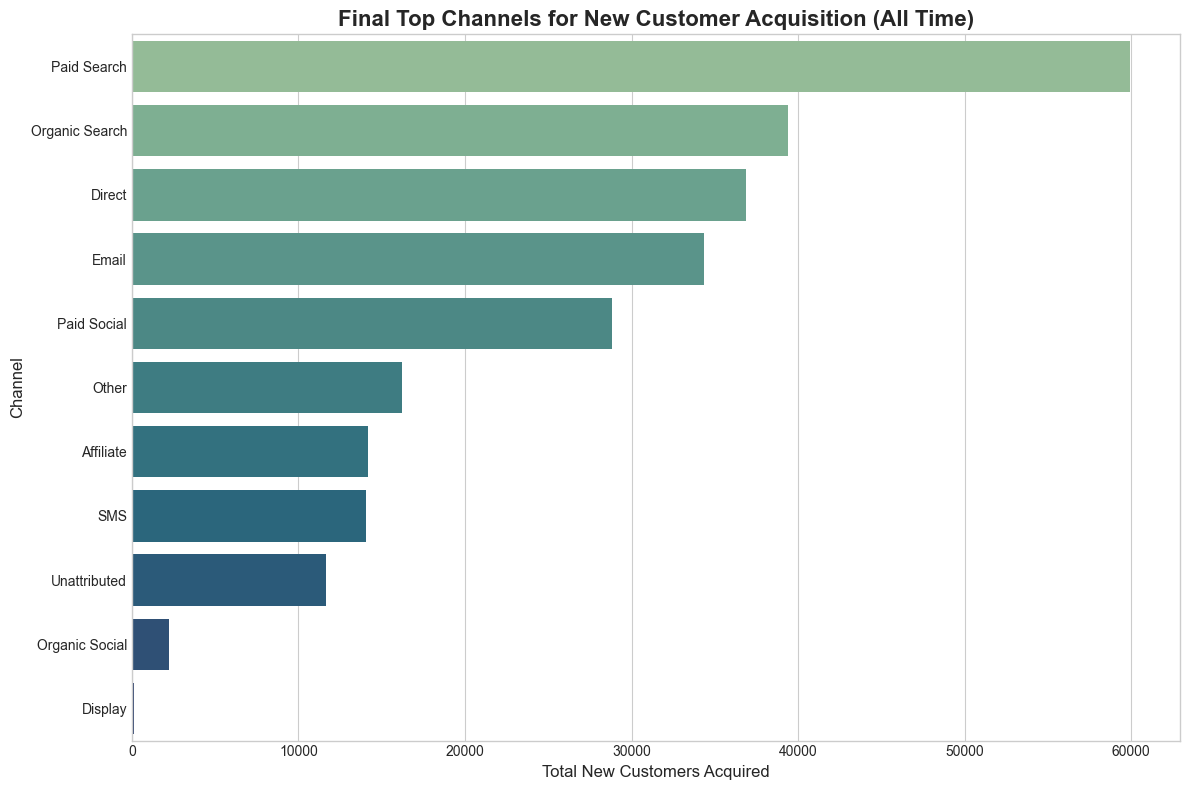

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def analyze_final_customer_contribution():
    """
    Analyzes and visualizes the definitive contribution of new vs. existing customers
    using a validated and consistent time period for all data sources.
    """
    try:
        # --- 1. Load Validated Monthly Data ---
        print("Loading validated monthly customer data files...")
        new_cust_df = pd.read_csv("cleaned_Cust By Channel-New.csv")
        ext_cust_df = pd.read_csv("cleaned_Cust By Channel-Ext.csv")

        # Add a 'customer_type' column to each dataframe before combining
        new_cust_df['customer_type'] = 'New'
        ext_cust_df['customer_type'] = 'Existing'

        # Combine into a single dataframe
        all_cust_df = pd.concat([new_cust_df, ext_cust_df])
        all_cust_df['date'] = pd.to_datetime(all_cust_df['date'])
        
        # --- Data Integrity Correction ---
        # To ensure an accurate comparison, we will only analyze the date range
        # for which we have complete data for all files.
        # The New Customer data ends in April 2025, so we will cap our analysis there.
        analysis_end_date = '2025-05-01'
        print(f"Data integrity check: Capping analysis at {analysis_end_date} to ensure fair comparison.")
        all_cust_df = all_cust_df[all_cust_df['date'] < analysis_end_date].copy()
        
        # We also need to apply this to the new_cust_df for the second chart
        new_cust_df = new_cust_df[new_cust_df['date'] < analysis_end_date].copy()


        # --- 2. Analyze Monthly Customer Composition ---
        print("Analyzing monthly customer composition...")
        monthly_composition = all_cust_df.groupby(['date', 'customer_type'])['value'].sum().unstack()

        # --- 3. Visualize Monthly Composition (Stacked Area Chart) ---
        print("Generating final monthly composition chart...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(15, 8))
        
        monthly_composition.plot(
            kind='area',
            stacked=True,
            ax=ax,
            alpha=0.7
        )
        
        ax.set_title('Final Monthly Active Customers: New vs. Existing', fontsize=16, weight='bold')
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Number of Customers', fontsize=12)
        ax.legend(title='Customer Type')
        
        plt.tight_layout()
        plt.savefig('final_monthly_customer_composition.png')
        print("✅ Final monthly composition chart saved to 'final_monthly_customer_composition.png'")
        plt.show()
        plt.close()

        # --- 4. Analyze New Customer Acquisition by Channel ---
        print("\nAnalyzing new customer acquisition by channel from monthly data...")
        # Filter for only new customers and sum them up by channel across all time
        new_cust_by_channel = new_cust_df.groupby('channel_name')['value'].sum().sort_values(ascending=False).reset_index()

        # --- 5. Visualize Top Channels for New Customers (Bar Chart) ---
        print("Generating final new customer acquisition chart...")
        fig, ax = plt.subplots(figsize=(12, 8))
        
        sns.barplot(
            x='value',
            y='channel_name',
            data=new_cust_by_channel,
            palette='crest',
            ax=ax,
            hue='channel_name',
            legend=False
        )
        
        ax.set_title('Final Top Channels for New Customer Acquisition (All Time)', fontsize=16, weight='bold')
        ax.set_xlabel('Total New Customers Acquired', fontsize=12)
        ax.set_ylabel('Channel', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('final_new_customer_acquisition_by_channel.png')
        print("✅ Final new customer acquisition chart saved to 'final_new_customer_acquisition_by_channel.png'")
        plt.show()
        plt.close()

    except FileNotFoundError as e:
        print(f"❌ ERROR: Could not find a required cleaned file: {e.filename}")
        print("Please ensure your 'cleaned_*.csv' files are in the same directory.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

# --- Run the final analysis ---
if __name__ == '__main__':
    analyze_final_customer_contribution()


## 📊 Customer Growth Analysis — Key Observations (CHART - 1)

---

### 🔍 Observation 1: Stagnant Growth with High Volatility
- The total number of **active customers** (top edge of the chart) is **not showing consistent growth**.
- Instead, the trend is **highly volatile**, with sharp **peaks and troughs**.
- 📉 This indicates the business may be **reliant on seasonal promotions** or campaign-driven bursts rather than steady, organic customer acquisition.

---

### 🔍 Observation 2: A "Leaky Bucket"
- The **orange area** (New Customers) represents a **large share of the total** every month.
- This reveals a pattern of **frequent new customer acquisition**, but poor **retention**.
- 💧 The business is pouring new users into a **"leaky bucket"** — with not enough existing customers being retained to sustain growth.
- A healthier trajectory would show the **blue area** (Existing Customers) **growing steadily** over time.

---

### 🔍 Observation 3: Strong Seasonality
- There are **consistent peaks** every year during the **holiday season (Nov/Dec)**.
- Noticeable **troughs appear in early months** (Jan/Feb), which aligns with **typical e-commerce patterns**.
- 📆 This seasonality should be factored into forecasting and campaign planning.


## 🚀 Customer Acquisition Channel Analysis — Key Observations (Chart - 2)

---

### 🔍 Observation 1: Search is the King of Acquisition
- **Paid Search** and **Organic Search** are the **top two channels** for acquiring new customers — by a significant margin.
- This aligns with their strong **ROAS**, further validating their strategic importance.
- 👑 Search channels are driving both **volume** and **profitability**.

---

### 🔍 Observation 2: Paid Social is *Not* a Top Acquisition Engine
- This is a **critical finding**.
- Despite having the **largest ad spend**, **Paid Social ranks only 5th** in new customer acquisition.
- It is being **outperformed by lower-cost channels** like **Direct** and **Email**.
- ❗ This reveals a major **misalignment between spend and performance**.

---

### 🔍 Observation 3: The Paid Social Dilemma is Clear
We now have **two key data points** confirming the issue with Paid Social:

1. **It has the worst ROAS** → The business is **losing money on each transaction**.
2. **It is not an efficient acquisition engine** → Relative to its cost, it delivers **very few new customers**.

**🧠 Insight:**  
- Paid Social is both **unprofitable** and **inefficient**.
- A comprehensive audit and reallocation of budget is recommended.



Loading validated monthly spend and new customer data...
Data integrity check: Capping analysis at 2025-05-01 for fair comparison.
Calculating true total spend by channel (including agency fees)...
Calculating total new customers by channel...
Combining data and calculating final overall CAC...

--- Final Overall Customer Acquisition Cost (CAC) by Channel ---
       channel  total_spend  total_new_customers         cac
2  paid social      3735853              28809.0  129.676594
0   affiliates      1586462              14194.0  111.769903
1  paid search      2249990              59935.0   37.540502

Generating final visualization...
✅ Final overall CAC analysis chart saved to 'final_overall_cac_analysis.png'


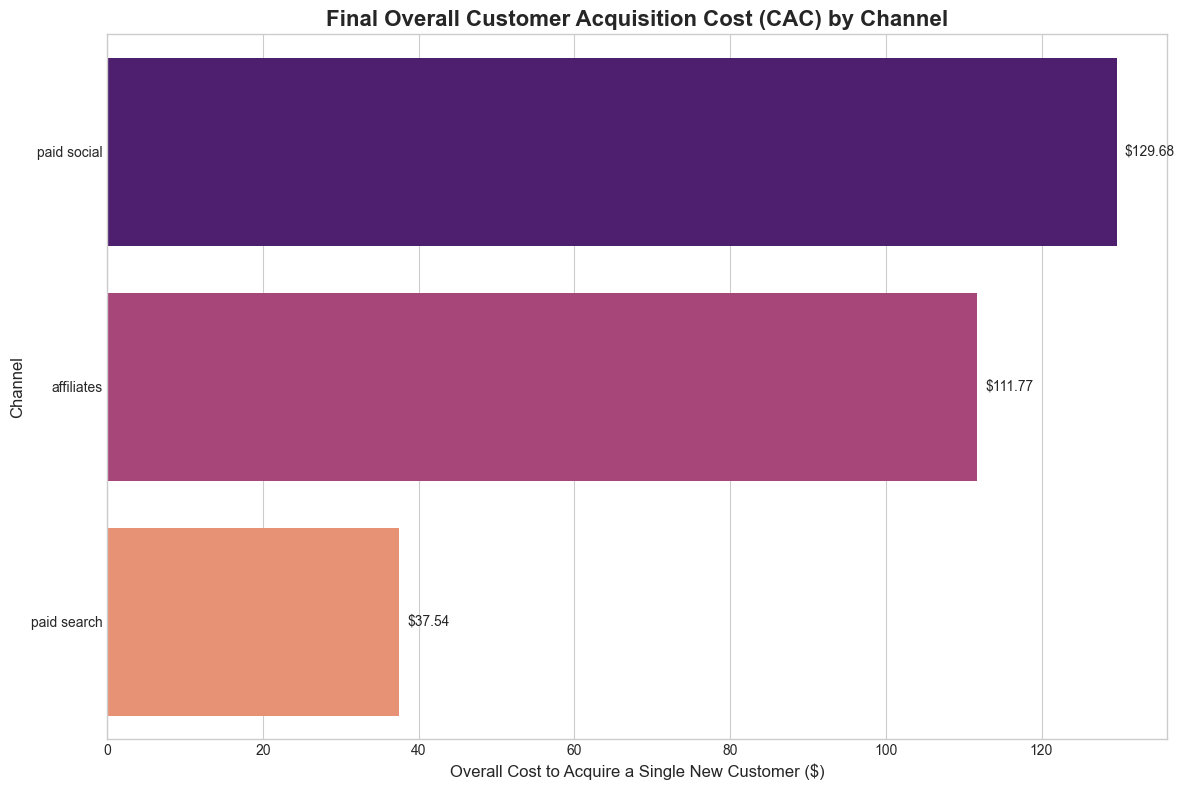

In [6]:
def analyze_overall_cac():
    """
    Calculates the definitive overall Customer Acquisition Cost (CAC) for each channel
    using a consistent and validated time period.
    """
    try:
        # --- 1. Load Validated Monthly Data ---
        print("Loading validated monthly spend and new customer data...")
        media_spend_df = pd.read_csv("cleaned_Media Spend by Channel.csv")
        new_cust_df = pd.read_csv("cleaned_Cust By Channel-New.csv")

        # Convert date columns to datetime objects
        media_spend_df['date'] = pd.to_datetime(media_spend_df['date'])
        new_cust_df['date'] = pd.to_datetime(new_cust_df['date'])

        # --- 2. Data Integrity Step: Ensure Consistent Time Period ---
        # I cap the analysis at the last month with complete data (April 2025)
        analysis_end_date = pd.to_datetime('2025-05-01')
        print(f"Data integrity check: Capping analysis at {analysis_end_date.date()} for fair comparison.")
        
        media_spend_df = media_spend_df[media_spend_df['date'] < analysis_end_date].copy()
        new_cust_df = new_cust_df[new_cust_df['date'] < analysis_end_date].copy()

        # --- 3. Calculate True Total Spend by Channel ---
        print("Calculating true total spend by channel (including agency fees)...")
        
        agency_fees_df = media_spend_df[media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        agency_fees_df['mapping_key'] = agency_fees_df['channel_name'].str.replace(" Agency", "", regex=False).str.lower()
        agency_fees_df['mapping_key'] = agency_fees_df['mapping_key'].replace({'affiliate': 'affiliates'})
        total_agency_fees = agency_fees_df.groupby('mapping_key')['value'].sum()

        direct_media_spend_df = media_spend_df[~media_spend_df['channel_name'].str.contains("Agency", na=False)].copy()
        direct_media_spend_df['mapping_key'] = direct_media_spend_df['channel_name'].str.replace(" Media", "", regex=False).str.lower()
        direct_media_spend_df['mapping_key'] = direct_media_spend_df['mapping_key'].replace({'affiliate': 'affiliates'})
        total_media_spend = direct_media_spend_df.groupby('mapping_key')['value'].sum()

        total_spend = total_media_spend.add(total_agency_fees, fill_value=0)
        total_spend.name = "total_spend"

        # --- 4. Calculate Total New Customers by Channel ---
        print("Calculating total new customers by channel...")
        new_cust_df['mapping_key'] = new_cust_df['channel_name'].str.lower()
        new_cust_df['mapping_key'] = new_cust_df['mapping_key'].replace({'affiliate': 'affiliates'})
        total_new_customers = new_cust_df.groupby('mapping_key')['value'].sum()
        total_new_customers.name = "total_new_customers"

        # --- 5. Combine and Calculate Overall CAC ---
        print("Combining data and calculating final overall CAC...")
        cac_df = pd.merge(total_spend, total_new_customers, left_index=True, right_index=True, how='left')
        
        cac_df['total_new_customers'] = cac_df['total_new_customers'].fillna(0)
        cac_df['cac'] = cac_df.apply(
            lambda row: row['total_spend'] / row['total_new_customers'] if row['total_new_customers'] > 0 else 0,
            axis=1
        )
        
        cac_df.reset_index(inplace=True)
        cac_df.rename(columns={'mapping_key': 'channel'}, inplace=True)
        cac_df = cac_df[cac_df['cac'] > 0].sort_values('cac', ascending=False)

        print("\n--- Final Overall Customer Acquisition Cost (CAC) by Channel ---")
        print(cac_df)

        # --- 6. Visualize the Final Results ---
        print("\nGenerating final visualization...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        barplot = sns.barplot(x='cac', y='channel', data=cac_df, palette='magma', ax=ax, hue='channel', legend=False)

        ax.set_title('Final Overall Customer Acquisition Cost (CAC) by Channel', fontsize=16, weight='bold')
        ax.set_xlabel('Overall Cost to Acquire a Single New Customer ($)', fontsize=12)
        ax.set_ylabel('Channel', fontsize=12)
        
        for p in barplot.patches:
            width = p.get_width()
            ax.text(width + 1, p.get_y() + p.get_height() / 2, f'${width:.2f}', va='center')
        
        plt.tight_layout()
        plt.savefig('final_overall_cac_analysis.png')
        print("✅ Final overall CAC analysis chart saved to 'final_overall_cac_analysis.png'")
        plt.show()
        plt.close()

    except FileNotFoundError as e:
        print(f"❌ ERROR: Could not find a required cleaned file: {e.filename}")
        print("Please ensure your 'cleaned_*.csv' files are in the same directory.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")

# --- Run the analysis ---
if __name__ == '__main__':
    analyze_overall_cac()


In [8]:
import numpy as np

def create_wholesale_dummy_data():
    """
    Generates a dummy DataFrame for the wholesale module with calculated KPIs.
    """
    # --- A. Create Dummy Data ---
    np.random.seed(42) # for reproducibility
    num_rows = 30
    retailers = ['Big Box Store', 'Boutique XYZ', 'Online Marketplace', 'Dept Store']
    
    data = {
        'retailer': np.random.choice(retailers, num_rows),
        'sku': [f'SKU{100+i}' for i in range(num_rows)],
        'units_ordered': np.random.randint(100, 500, size=num_rows),
        'units_sold': np.random.randint(50, 400, size=num_rows),
        'on_hand': np.random.randint(20, 200, size=num_rows),
        'wholesale_dollars': np.random.randint(5000, 20000, size=num_rows)
    }
    df = pd.DataFrame(data)

    # Ensure units_shipped is logical (<= units_ordered)
    df['units_shipped'] = df['units_ordered'] - np.random.randint(0, 50, size=num_rows)
    df['units_shipped'] = df['units_shipped'].clip(lower=0)

    # Generate financial numbers as a percentage of wholesale_dollars
    df['discounts'] = df['wholesale_dollars'] * np.random.uniform(0.05, 0.15, size=num_rows)
    df['returns_dollars'] = df['wholesale_dollars'] * np.random.uniform(0.02, 0.1, size=num_rows)
    df['markdowns_dollars'] = df['wholesale_dollars'] * np.random.uniform(0.01, 0.05, size=num_rows)

    # --- B. Calculate KPIs ---
    
    # Sell-through % = units_sold / (units_sold + on_hand)
    df['sell_through_pct'] = df['units_sold'] / (df['units_sold'] + df['on_hand'])
    
    # Weeks-of-Supply = on_hand / avg_weekly_units_sold
    # Assuming a 4-week period for average weekly units
    avg_weekly_units_sold = df['units_sold'] / 4
    df['weeks_of_supply'] = df['on_hand'] / avg_weekly_units_sold.replace(0, np.nan) # Avoid division by zero
    
    # Fill-Rate % = units_shipped / units_ordered
    df['fill_rate_pct'] = df['units_shipped'] / df['units_ordered']
    
    # Gross-to-Net Margin = (wholesale$ – discounts – returns$ – markdowns$) / wholesale$
    net_revenue = df['wholesale_dollars'] - df['discounts'] - df['returns_dollars'] - df['markdowns_dollars']
    df['net_margin_pct'] = net_revenue / df['wholesale_dollars']

    # Clean up potential NaN/Inf values from division
    df.fillna(0, inplace=True)
    
    print("Dummy wholesale DataFrame created successfully.")
    return df

# --- Create and display the DataFrame ---
if __name__ == '__main__':
    wholesale_df = create_wholesale_dummy_data()
    
    # Display the final DataFrame with KPIs, ready for plotting
    print(wholesale_df[['retailer', 'sku', 'sell_through_pct', 'net_margin_pct', 'wholesale_dollars']].head())

Dummy wholesale DataFrame created successfully.
             retailer     sku  sell_through_pct  net_margin_pct  \
0  Online Marketplace  SKU100          0.742347        0.824756   
1          Dept Store  SKU101          0.707207        0.795520   
2       Big Box Store  SKU102          0.845824        0.832932   
3  Online Marketplace  SKU103          0.703448        0.827634   
4  Online Marketplace  SKU104          0.692171        0.821551   

   wholesale_dollars  
0              18067  
1               8104  
2              12215  
3              17790  
4               7454  


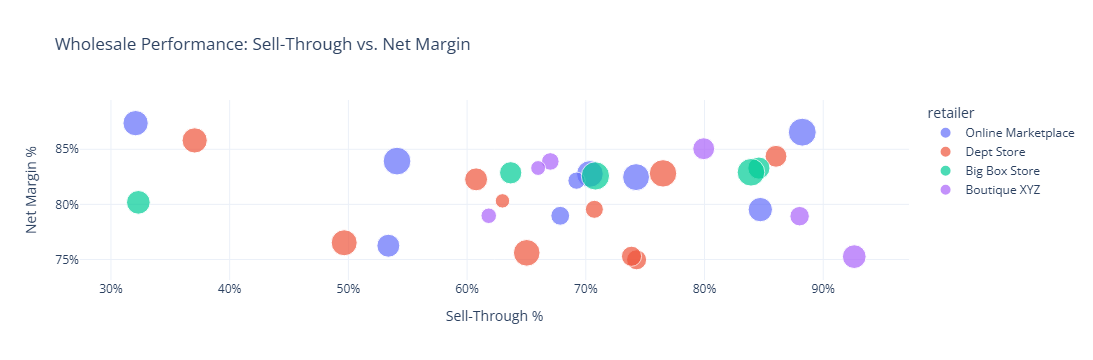

In [9]:
import plotly.express as px
# This function is the same as before, included here so the code is runnable
def create_wholesale_dummy_data():
    np.random.seed(42)
    num_rows = 30
    retailers = ['Big Box Store', 'Boutique XYZ', 'Online Marketplace', 'Dept Store']
    data = {
        'retailer': np.random.choice(retailers, num_rows),
        'sku': [f'SKU{100+i}' for i in range(num_rows)],
        'units_ordered': np.random.randint(100, 500, size=num_rows),
        'units_sold': np.random.randint(50, 400, size=num_rows),
        'on_hand': np.random.randint(20, 200, size=num_rows),
        'wholesale_dollars': np.random.randint(5000, 20000, size=num_rows)
    }
    df = pd.DataFrame(data)
    df['units_shipped'] = df['units_ordered'] - np.random.randint(0, 50, size=num_rows)
    df['units_shipped'] = df['units_shipped'].clip(lower=0)
    df['discounts'] = df['wholesale_dollars'] * np.random.uniform(0.05, 0.15, size=num_rows)
    df['returns_dollars'] = df['wholesale_dollars'] * np.random.uniform(0.02, 0.1, size=num_rows)
    df['markdowns_dollars'] = df['wholesale_dollars'] * np.random.uniform(0.01, 0.05, size=num_rows)
    df['sell_through_pct'] = df['units_sold'] / (df['units_sold'] + df['on_hand'])
    avg_weekly_units_sold = df['units_sold'] / 4
    df['weeks_of_supply'] = df['on_hand'] / avg_weekly_units_sold.replace(0, np.nan)
    df['fill_rate_pct'] = df['units_shipped'] / df['units_ordered']
    net_revenue = df['wholesale_dollars'] - df['discounts'] - df['returns_dollars'] - df['markdowns_dollars']
    df['net_margin_pct'] = net_revenue / df['wholesale_dollars']
    df.fillna(0, inplace=True)
    return df

# Create the dataframe
wholesale_df = create_wholesale_dummy_data()

# --- C. Create the Visualization ---
fig_wholesale = px.scatter(
    wholesale_df,
    x="sell_through_pct",      #
    y="net_margin_pct",        #
    size="wholesale_dollars",  #
    color="retailer",          #
    hover_name="sku",
    title="Wholesale Performance: Sell-Through vs. Net Margin",
    labels={
        "sell_through_pct": "Sell-Through %",
        "net_margin_pct": "Net Margin %",
        "wholesale_dollars": "Wholesale Revenue ($)"
    },
    template="plotly_white"
)

# Format axes as percentages for clarity
fig_wholesale.update_layout(
    xaxis_tickformat='.0%',
    yaxis_tickformat='.0%'
)

fig_wholesale.show()